# Cat and Dog binary classifier model

- This notebook need a dataset like this https://drive.google.com/file/d/15duuBYgSiWmy8Ivr1b_ngiydGCNS10t7/view
- Dataset need images of cats and dogs
- We going to train a model with data augmentation and another one without it
- The best model have a validation accuracy of ~ 0.755
- In this notebook i learned about:

* Data augmentation creating images motifiers from original images
* Split dataset in two categories
* Split datasets in validation and train sets
* Keras generators to train with more memory handling efficient
* Three Block VGG Architecture for Convulation Neural Network 
* CNN implementations
* Case of use of SIGMOID activation layer and not SOFTMAX because is a binary clasifier and not categorical clasifier
* Keras model callbacks to early stopping, change learning rate to about oscillation and save best model meanwhile model in training
* NPZ Saving strategy
* Prediction of images and showing using OpenCV

This notebook was useful to learning things but actually it not the best approach for binary classifier of dogs and cats, in the future i hope to know how do betters models for this job

In [24]:
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import sys
import os
import shutil

MAIN_PATH = "C:\\Users\Charly\Data Augmentation"

# This folder have cats and dogs images and we going to split it
mypath =  join(MAIN_PATH, "datasets\catsvsdogs\images") 

file_names = [f for f in listdir(mypath) if  isfile(join(mypath, f))]

print(str(len(file_names)) + " Images loaded")

3002 Images loaded


## Splitting our loaded image into a training and test/validation dataset

- We also need to store their labels y_train, y_test
- We re-size our images here to maintain a constant dimension of 150x150
- We are going to use 1000 images of dogs and 1000 images of cats as our training data
- For our test/validation dataset we are going to use 500 of each class
- Dogs will be labels 1 and cats 0
- We store our new images in the following directories

* /datasets/catsvsdogs/train/dogs
* /datasets/catsvsdogs/train/cats
* /datasets/catsvsdogs/validation/dogs
* /datasets/catsvsdogs/validation/cats

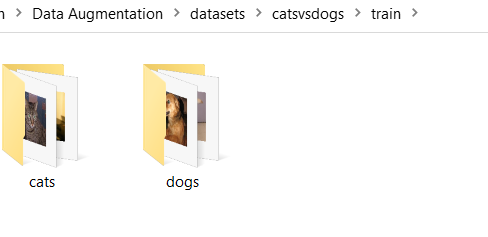

In [25]:
import cv2
import numpy as np
import sys
import os
import shutil

# Extract 1000 for our training data and 500 for our validation set
# Takes about -20 seconds to run 

dog_count = 0
cat_count = 0
training_size = 1000
test_size = 500
training_images = [] 
training_labels = []
test_images = []
test_labels = []
size = 150
dog_dir_train = r"{0}\datasets\catsvsdogs\train\dogs".format(MAIN_PATH)
cat_dir_train = r"{0}\datasets\catsvsdogs\train\cats".format(MAIN_PATH)
dog_dir_val = r"{0}\datasets\catsvsdogs\validation\dogs".format(MAIN_PATH)
cat_dir_val = r"{0}\datasets\catsvsdogs\validation\cats".format(MAIN_PATH)

def make_dir(directory):
    if os.path.exists(directory):
        shutil.rmtree(directory)
    os.makedirs(directory)

make_dir(dog_dir_train)
make_dir(cat_dir_train)
make_dir(dog_dir_val)
make_dir(cat_dir_val)

def getZeros(number):
    if(number> 10 and number < 100):
        return "0"
    if(number <10):
        return "00"
    else:
        return ""
    

for i, file in enumerate(file_names):
    if file_names[i][0] == "d":
        # Dogs
        dog_count += 1
        image = cv2.imread(join(mypath, file))
        image = cv2.resize(image, (size, size), interpolation =cv2.INTER_AREA)
        if dog_count <= training_size:
            training_images.append(image)
            training_labels.append(1)
            zeros = getZeros(dog_count)
            cv2.imwrite(dog_dir_train + "\dog" + str(zeros) + str(dog_count) + ".jpg", image)
        if dog_count > training_size and dog_count <= training_size + test_size:
            test_images.append(image)
            test_labels.append(1)
            zeros = getZeros(dog_count - 1000)
            cv2.imwrite(dog_dir_val + "\dog" + str(zeros) + str(dog_count - 1000) + ".jpg", image)
    if file_names[i][0] == "c":
        # Cats
        cat_count += 1
        image = cv2.imread(join(mypath, file))
        image = cv2.resize(image, (size, size), interpolation =cv2.INTER_AREA)
        if cat_count <= training_size:
            training_images.append(image)
            training_labels.append(0)
            zeros = getZeros(cat_count)
            cv2.imwrite(cat_dir_train + "\cat" + str(zeros) + str(cat_count) + ".jpg", image)
        if cat_count > training_size and cat_count <= training_size + test_size:
            test_images.append(image)
            test_labels.append(0)
            zeros = getZeros(cat_count - 1000)
            cv2.imwrite(cat_dir_val + "\cat" + str(zeros) + str(cat_count - 1000) + ".jpg", image)
    if dog_count == training_size + test_size and cat_count == training_size + test_size:
        break

print("Training and Test Data Extraction Complete")

Training and Test Data Extraction Complete


# Save dataset in NPZ files

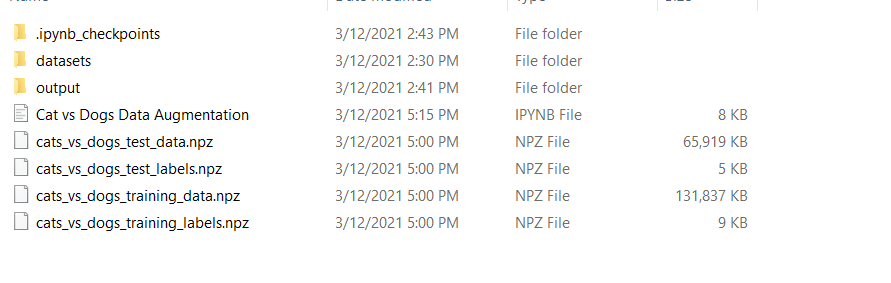

In [44]:
np.savez('cats_vs_dogs_training_data.npz', np.array(training_images))
np.savez('cats_vs_dogs_training_labels.npz', np.array(training_labels))
np.savez('cats_vs_dogs_test_data.npz', np.array(test_images))
np.savez('cats_vs_dogs_test_labels.npz', np.array(test_labels))

# Function loader to get npz files to train models


In [7]:
def load_data_training_and_test(datasetname):
    npzfile = np.load(datasetname + "_training_data.npz")
    train = npzfile['arr_0']

    npzfile = np.load(datasetname + "_training_labels.npz")
    train_labels = npzfile['arr_0']

    npzfile = np.load(datasetname + "_test_data.npz")
    test = npzfile['arr_0']

    npzfile = np.load(datasetname + "_test_labels.npz")
    test_labels = npzfile['arr_0']
    
    return (train, train_labels), (test, test_labels)

# Format data to use into keras CNN

In [8]:
(x_train, y_train), (x_test, y_test) = load_data_training_and_test('cats_vs_dogs')

# Reshaping our label data from 2000 to 2000,1 and test data from 1000 to 1000, 1
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

# Change our image type to float32
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('TRAIN SHAPES X, Y')
print(x_train.shape)
print(y_train.shape)
print('TEST SHAPES X, Y')
print(x_test.shape)
print(y_test.shape)

TRAIN SHAPES X, Y
(2000, 150, 150, 3)
(2000, 1)
TEST SHAPES X, Y
(1000, 150, 150, 3)
(1000, 1)


# Model definition sigmoid using  instead softmax

In [10]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
import os

batch_size = 16
epochs = 15
img_rows = x_train[0].shape[0]
img_cols = x_train[1].shape[0]
input_shape = (img_rows, img_cols, 3)

# Three Block VGG Model

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

opt = SGD(lr=0.001, momentum=0.9)

model.compile(
    loss='binary_crossentropy', 
    optimizer='rmsprop', 
    metrics=['accuracy'])


print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0

# Train modal and save it (Without Data Augmentation)

In [10]:
history = model.fit(
    x_train,
    y_train,
    batch_size = batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = (x_test, y_test),
    shuffle=True
)

model.save('CATS_VS_DOGS_CLASSIFIER.h5')

score = model.evaluate(x_test, y_test, verbose=1)
print(
"Test Loss: ", score[0],  " - - - "
"Test Accuracy: ", score[1]
)

Without Data Augmentation for the images:

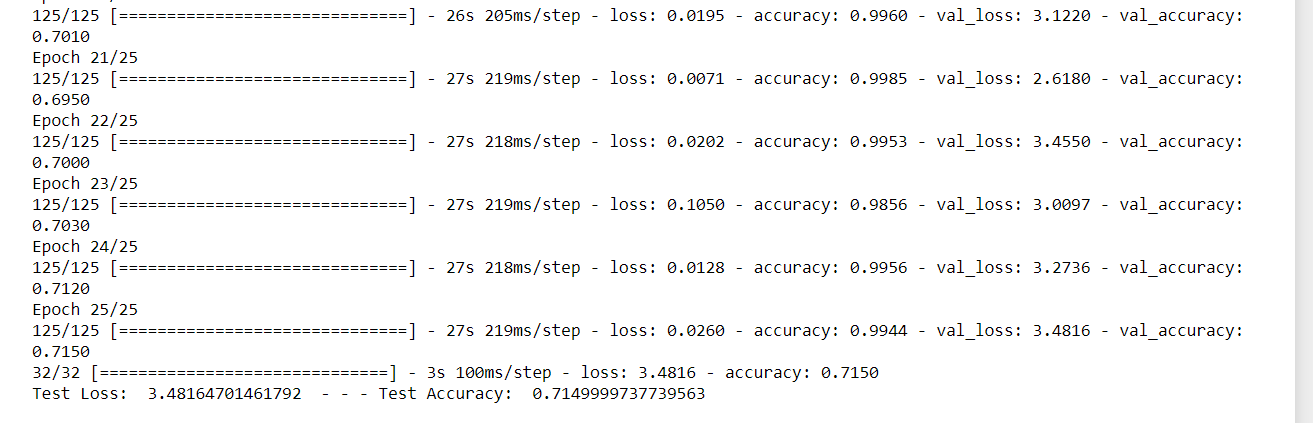

# Test models

CATS_VS_DOGS_CLASSIFIER_DATA_AUGMENTATED.h5

CATS_VS_DOGS_CLASSIFIER.h5

In [22]:
import cv2
import numpy as np

from keras.models import load_model

classifier = load_model('CATS_VS_DOGS_CLASSIFIER_DATA_AUGMENTATED.h5')

def draw_test(name, pred, input_im):
    BLACK = [0, 0, 0]
    # CATS_VS_DOGS_CLASSIFIER.h5
#     if pred == 0:
#         pred = "Un gato"
#     if pred == 1:
#         pred = "Un perro"
    # CATS_VS_DOGS_CLASSIFIER_DATA_AUGMENTATED.h5
    if pred < .5:
        pred = "Un gato"
    else:
        pred = "Un perro"
    expanded_image = cv2.copyMakeBorder(input_im, 0, 0, 0, imageL.shape[0], cv2.BORDER_CONSTANT, value=BLACK)
    cv2.putText(expanded_image, str(pred), (252, 70), cv2.FONT_HERSHEY_COMPLEX_SMALL, .7, (0, 255, 0), 2)
    cv2.imshow(name, expanded_image)
    

for i in range(0, 10):
    rand = np.random.randint(0, len(x_test))
    input_im = x_test[rand]
    imageL = cv2.resize(input_im, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
    input_im = input_im.reshape(1, 150, 150, 3)
    prediction = model.predict_classes(input_im)[0][0] # CATS_VS_DOGS_CLASSIFIER.h5
    draw_test("Prediction", prediction, imageL)
    cv2.waitKey(0)
    

cv2.destroyAllWindows()

# Create ImageDataGenerator instance for train and test

In [11]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen  = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1. / 255,
)

# We dont have manipulate the test dataset, just the training
test_datagen = ImageDataGenerator(rescale=1./255)

# I cant understand the name test_generator for this one
train_it = train_datagen.flow_from_directory(
        'datasets/catsvsdogs/train',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

test_it = test_datagen.flow_from_directory(
        'datasets/catsvsdogs/validation',
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Callbacks for save models and early stopping

## Checkpoint to monitor the model in each epoch and pick the better one:

We going to use here the callbacks argument in the fit method to monito the validation loss to save the best model and avoid a overfitted model

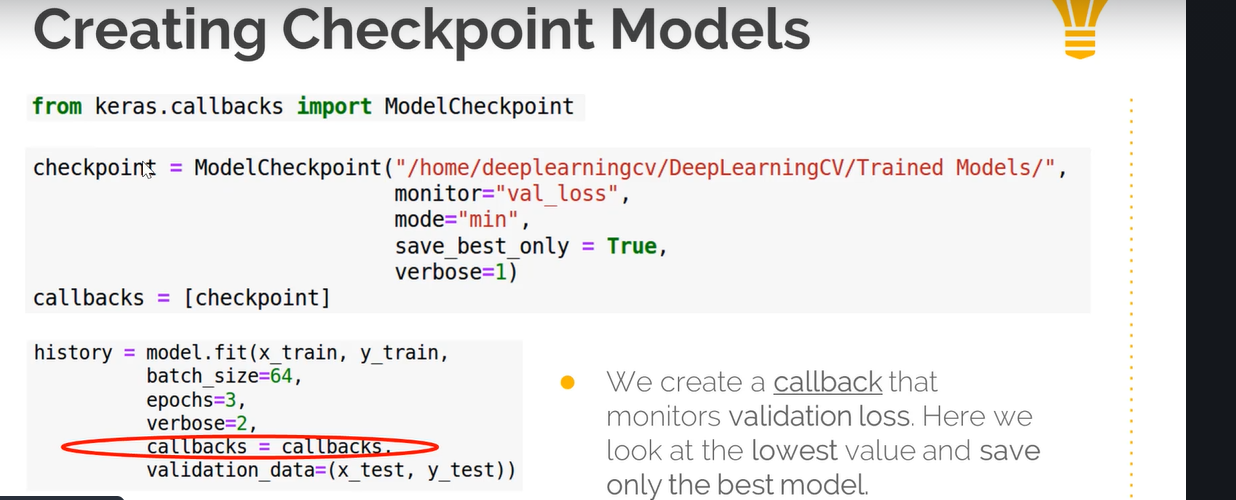


## Early stopping to save physical resources and time

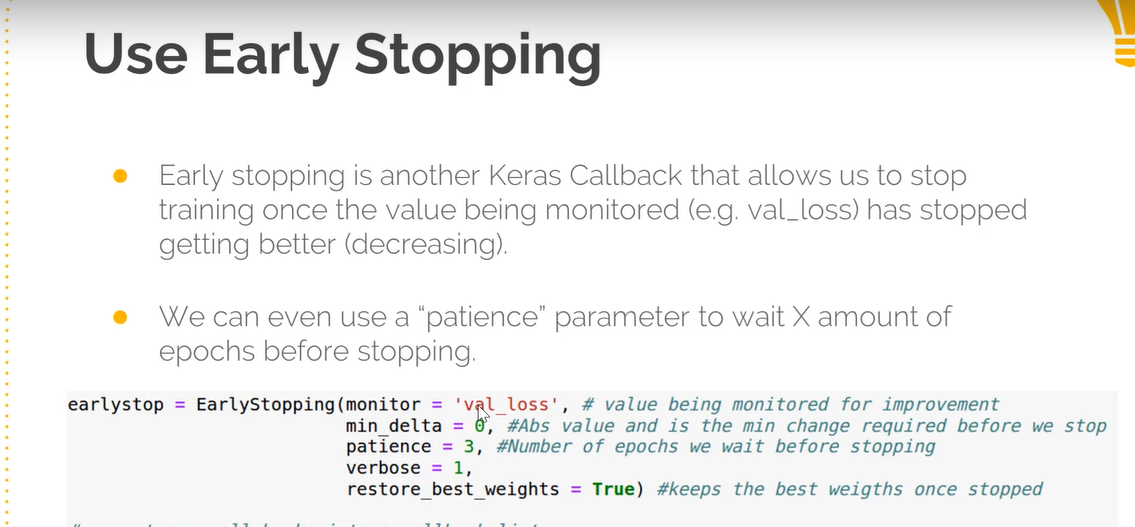

## Reducing learning rate on plateau

To avoid oscillation around the global minimun by attempting to reduce the learing rate by a centain fact. If no improvement is seen  in our monitored metric (val_loss typically), we cait the patience parameters (N epochs) then this callback reduce the learning rate by a factor

In [26]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "{0}\ModelCheckpointOutput".format(MAIN_PATH),
    monitor="val_loss",
    mode='min',
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=1,
    restore_best_weights=True
)


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    verbose=1,
    min_delta=0.0001
)


callbacks = [checkpoint, earlystop, reduce_lr]

# Train model with data augmentation

In [20]:
# https://stackoverflow.com/questions/49922252/choosing-number-of-steps-per-epoch
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit
# http://localhost:8888/tree/Data%20Augmentation/datasets/catsvsdogs
# https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/#:~:text=The%20Dogs%20vs.,deep%20learning%20convolutional%20neural%20networks.
history = model.fit(
    train_it, 
    steps_per_epoch=len(train_it),
    validation_data=test_it, 
    validation_steps=len(test_it), 
    epochs=epochs, 
    verbose=1,
    callbacks=[callbacks]
)

model.save('CATS_VS_DOGS_CLASSIFIER_DATA_AUGMENTATED.h5')

Epoch 1/15
125/125 [==============================] - 35s 284ms/step - loss: 0.6441 - accuracy: 0.6615 - val_loss: 0.6019 - val_accuracy: 0.6880

Epoch 00001: val_loss improved from inf to 0.60189, saving model to C:\Users\Sotfvision\Data Augmentation\ModelCheckpointOutput
INFO:tensorflow:Assets written to: C:\Users\Sotfvision\Data Augmentation\ModelCheckpointOutput\assets
Epoch 2/15
125/125 [==============================] - 41s 323ms/step - loss: 0.6308 - accuracy: 0.6615 - val_loss: 0.6021 - val_accuracy: 0.6820

Epoch 00002: val_loss did not improve from 0.60189
Epoch 3/15
125/125 [==============================] - 42s 335ms/step - loss: 0.6166 - accuracy: 0.6745 - val_loss: 0.7862 - val_accuracy: 0.6160

Epoch 00003: val_loss did not improve from 0.60189
Epoch 4/15
125/125 [==============================] - 41s 327ms/step - loss: 0.5904 - accuracy: 0.6895 - val_loss: 0.5974 - val_accuracy: 0.6940

Epoch 00004: val_loss improved from 0.60189 to 0.59737, saving model to C:\Users\Sot

In [52]:
_, acc = model.evaluate(test_it, steps=len(test_it), verbose=1)
print('> %.3f' % (acc * 100.0))

63/63 [==============================] - 4s 61ms/step - loss: 0.6038 - accuracy: 0.7130
> 71.300


# Checking Data Augmentation Images

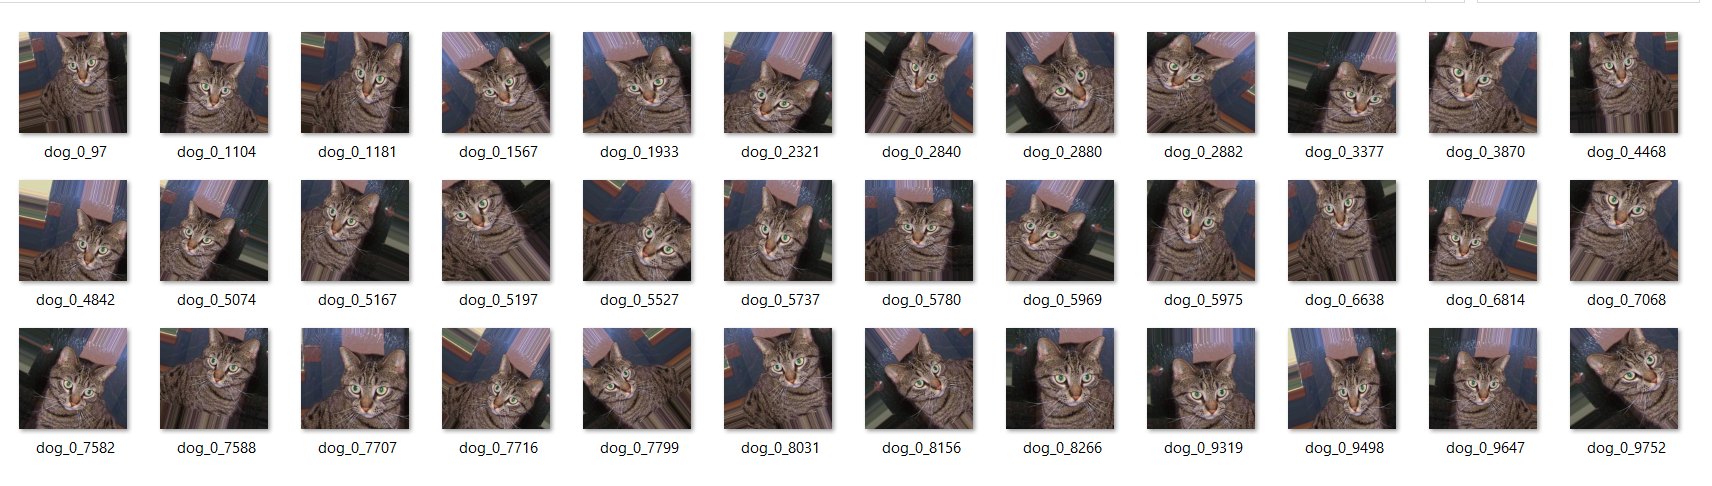

In [1]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

img = load_img('cat.jpg')

x = img_to_array(img)
x = x.reshape((1,)+ x.shape)
i = 0

for batch in datagen.flow(x, save_to_dir='output', save_prefix='dog', save_format='jpeg'):
    i += 1
    if i > 35:
        break